In [1]:
import os, itertools

from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from classifiers import MNORM_DNN
from trainers import Trainer
from utils import batch_run
from attacks import GM

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


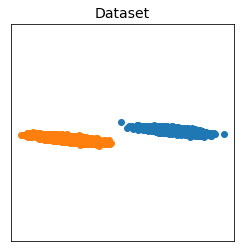

In [2]:
means = [[1.2, 0.1], [-1.2, -0.1]]
cov = [[0.1,-0.01],[-0.01,0.002]]
size = 3000

np.random.seed(0)

Xs = np.concatenate([np.random.multivariate_normal(mean=means[i], cov=cov, size=size) for i in range(2)], axis=0)
Xs = (Xs - np.min(Xs)) / (np.max(Xs) - np.min(Xs)) * 2 - 1
Ys = np.concatenate([np.ones(shape=size) * i for i in range(2)], axis=0)
data_train = np.c_[Xs, Ys]

np.random.shuffle(data_train)
data_train = (data_train[:,:2], data_train[:,2])

plt.figure(figsize=(4,4))
plt.scatter(Xs[:3000,0], Xs[:3000,1], label='Class 1')
plt.scatter(Xs[3000:,0], Xs[3000:,1], label='Class 2')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.xticks([])
plt.yticks([])
plt.title('Dataset', fontsize=14)
plt.show()

In [3]:
use_batchnorm = False
droprate = None
snbeta = None
l2rate = None

attack = GM
attack_params = [('eps', 0.25), ('step_size', 2), ('n_steps', 40), ('norm', '2')]

logdir = 'tf_logs/exp4/'
if use_batchnorm : logdir += 'batchnorm/'
if droprate : logdir += 'dropout/{}/'.format(droprate)
if snbeta : logdir += 'sn/{}/'.format(snbeta)
if l2rate : logdir += 'l2/{}/'.format(l2rate)

if attack : logdir += 'adv/{}/{}/'.format(attack.__name__, '_'.join([str(v) for k, v in attack_params]))

if logdir.split('/')[-2] == 'exp4' : logdir += 'standard/'

print(logdir)

tf.reset_default_graph()

DNN = MNORM_DNN(logdir, 2, tf.nn.relu, use_batchnorm, droprate, snbeta, l2rate, attack, dict(attack_params))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

trainer = Trainer(sess, DNN, data_train)
trainer.train(n_epochs=10, p_epochs=1)

sess.close()

tf_logs/exp5/adv/GM/0.25_2_40_2/
Epoch : 1   | Loss : 0.51313 | Accuracy : 0.96750 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 2   | Loss : 0.27715 | Accuracy : 0.97900 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 3   | Loss : 0.15937 | Accuracy : 0.98000 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 4   | Loss : 0.11054 | Accuracy : 0.98050 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 5   | Loss : 0.08789 | Accuracy : 0.98050 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 6   | Loss : 0.07572 | Accuracy : 0.98067 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 7   | Loss : 0.06847 | Accuracy : 0.98067 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 8   | Loss : 0.06384 | Accuracy : 0.98083 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 9   | Loss : 0.06074 | Accuracy : 0.98083 | Test Accuracy : nan | Adv Accuracy : nan
Epoch : 10  | Loss : 0.05860 | Accuracy : 0.98083 | Test Accuracy : nan | Adv Accuracy : nan


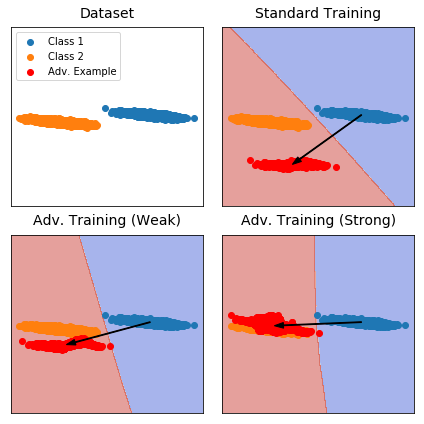

In [22]:
x = np.linspace(-1.1, 1.1, size)
y = np.linspace(-1.1, 1.1, size)

xx, yy = np.meshgrid(x, y)

x1_data = np.reshape(xx, [-1,1])
x2_data = np.reshape(yy, [-1,1])
x_data = np.concatenate((x1_data, x2_data), axis=-1)

tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = MNORM_DNN('tf_logs/exp4/standard/', 2, tf.nn.relu)
DNN.load(sess)

gm = GM(DNN, eps=1.0, step_size=2, n_steps=40, norm='2')
data_adv1 = gm.attack(sess, (Xs, Ys))

inf_res1 = batch_run(lambda x: sess.run(DNN.yi, feed_dict={DNN.X: x}), x_data).reshape(size,size)

sess.close()

tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = MNORM_DNN('tf_logs/exp4/adv/GM/0.25_2_40_2/', 2, tf.nn.relu)
DNN.load(sess)

gm = GM(DNN, eps=1.0, step_size=2, n_steps=40, norm='2')
data_adv2 = gm.attack(sess, (Xs, Ys))

inf_res2 = batch_run(lambda x: sess.run(DNN.yi, feed_dict={DNN.X: x}), x_data).reshape(size,size)

sess.close()

tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = MNORM_DNN('tf_logs/exp4/adv/GM/0.5_2_40_2/', 2, tf.nn.relu)
DNN.load(sess)

gm = GM(DNN, eps=1.0, step_size=2, n_steps=40, norm='2')
data_adv3 = gm.attack(sess, (Xs, Ys))

inf_res3 = batch_run(lambda x: sess.run(DNN.yi, feed_dict={DNN.X: x}), x_data).reshape(size,size)

sess.close()

plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
plt.scatter(Xs[:3000,0], Xs[:3000,1], label='Class 1')
plt.scatter(Xs[3000:,0], Xs[3000:,1], label='Class 2')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.xticks([])
plt.yticks([])
plt.title('Dataset', fontsize=14, pad=10)

plt.scatter(10, 10, color='r', label='Adv. Example')

plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.contourf(xx, yy, inf_res1, alpha=0.5, cmap='coolwarm')

plt.scatter(Xs[:3000,0], Xs[:3000,1], label='Class 1')
plt.scatter(Xs[3000:,0], Xs[3000:,1], label='Class 2')

plt.scatter(data_adv1[:3000,0], data_adv1[:3000,1], color='r', label='Attack 1')

center1, center2 = np.mean(Xs[:3000], axis=0), np.mean(data_adv1[:3000], axis=0)
delta = center2 - center1
plt.arrow(center1[0], center1[1], delta[0], delta[1], length_includes_head=True, width=0.01, head_width=0.07, color='k')

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.xticks([])
plt.yticks([])

plt.title('Standard Training', fontsize=14, pad=10)

plt.subplot(2,2,3)
plt.contourf(xx, yy, inf_res2, alpha=0.5, cmap='coolwarm')

plt.scatter(Xs[:3000,0], Xs[:3000,1], label='Class 1')
plt.scatter(Xs[3000:,0], Xs[3000:,1], label='Class 2')

plt.scatter(data_adv2[:3000,0], data_adv2[:3000,1], color='r', label='Attack 1')

center1, center2 = np.mean(Xs[:3000], axis=0), np.mean(data_adv2[:3000], axis=0)
delta = center2 - center1
plt.arrow(center1[0], center1[1], delta[0], delta[1], length_includes_head=True, width=0.01, head_width=0.07, color='k')

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.xticks([])
plt.yticks([])

plt.title('Adv. Training (Weak)', fontsize=14, pad=10)

plt.subplot(2,2,4)
plt.contourf(xx, yy, inf_res3, alpha=0.5, cmap='coolwarm')

plt.scatter(Xs[:3000,0], Xs[:3000,1], label='Class 1')
plt.scatter(Xs[3000:,0], Xs[3000:,1], label='Class 2')

plt.scatter(data_adv3[:3000,0], data_adv3[:3000,1], color='r', label='Attack 1')

center1, center2 = np.mean(Xs[:3000], axis=0), np.mean(data_adv3[:3000], axis=0)
delta = center2 - center1
plt.arrow(center1[0], center1[1], delta[0], delta[1], length_includes_head=True, width=0.01, head_width=0.07, color='k')

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.xticks([])
plt.yticks([])

plt.title('Adv. Training (Strong)', fontsize=14, pad=10)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.16)

plt.savefig('figs/boundary_experiment2.jpg', bbox_inches='tight', dpi=300)

plt.show()